<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/dexpi_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Dependencies

Install the NeqSim and DEXPI toolchain so the later steps can call straight into the Java implementation and consume the XML with pyDEXPI.


In [ ]:
# Install the runtime dependencies needed for DEXPI<->NeqSim<->pyDEXPI workflows.

%pip install --quiet neqsim pyDEXPI defusedxml lxml


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Load DEXPI Example Assets

Copy the DEXPI XML reference file from the NeqSim Java tests into a local artifacts folder so the notebook can modify it safely.


In [ ]:
from pathlib import Path


import shutil




# Resolve the repository root even if the notebook runs from a subdirectory.
cwd = Path.cwd().resolve()
for candidate in (cwd,) + tuple(cwd.parents):
    if (candidate / "pom.xml").exists() and (candidate / "src").is_dir():
        repo_root = candidate
        break
else:
    raise FileNotFoundError("Could not locate the NeqSim repository root from the current working directory.")


source_xml = repo_root / "src/test/resources/dexpi/C01V04-VER.EX01.xml"


assets_dir = Path("notebook_artifacts")


assets_dir.mkdir(exist_ok=True)


dexpi_xml_path = assets_dir / source_xml.name


if not source_xml.is_file():
    raise FileNotFoundError(f"Expected DEXPI example at {source_xml}")


shutil.copy2(source_xml, dexpi_xml_path)


dexpi_xml_path



WindowsPath('notebook_artifacts/C01V04-VER.EX01.xml')

## 3. Construct NeqSim Process Model

Bootstrap the JVM via JPype, locate the NeqSim jar shipped with the Python package, and rebuild the PlateHeatExchanger topology used in the Java unit test.


In [ ]:
import importlib

from pathlib import Path



import jpype

import jpype.imports

import neqsim



# Boot the JVM once and expose the Java classes needed for the DEXPI workflow.

if not jpype.isJVMStarted():

    neqsim_package = Path(neqsim.__file__).resolve().parent

    jar_candidates = sorted(neqsim_package.rglob("*.jar"))

    if not jar_candidates:

        raise FileNotFoundError("No NeqSim jar found in the installed package.")

    classpath = [str(jar) for jar in jar_candidates]

    jpype.startJVM(classpath=classpath)



from jpype import JClass



ProcessSystem = JClass("neqsim.process.processmodel.ProcessSystem")

DexpiProcessUnit = JClass("neqsim.process.processmodel.DexpiProcessUnit")

DexpiStream = JClass("neqsim.process.processmodel.DexpiStream")

DexpiMetadata = JClass("neqsim.process.processmodel.DexpiMetadata")

DexpiXmlWriter = JClass("neqsim.process.processmodel.DexpiXmlWriter")

DexpiXmlReader = JClass("neqsim.process.processmodel.DexpiXmlReader")

EquipmentEnum = JClass("neqsim.process.equipment.EquipmentEnum")

SystemSrkEos = JClass("neqsim.thermo.system.SystemSrkEos")



process_system = ProcessSystem("DEXPI demo process")



base_fluid = SystemSrkEos(298.15, 50.0)

base_fluid.addComponent("methane", 0.9)

base_fluid.addComponent("ethane", 0.1)

base_fluid.createDatabase(True)

base_fluid.setMixingRule(2)

base_fluid.init(0)



feed_stream = DexpiStream("NG-01 feed", base_fluid.clone(), "PipingNetworkSegment", "L-100", "NG-01")

feed_stream.setSpecification("TP")

feed_stream.setPressure(40.0, "bara")

feed_stream.setTemperature(35.0, "C")

feed_stream.setFlowRate(1.2, "MSm3/day")

process_system.addUnit(feed_stream.getName(), feed_stream)



heat_exchanger = DexpiProcessUnit(

    "P-101",

    "PlateHeatExchanger",

    EquipmentEnum.valueOf("HeatExchanger"),

    "L-100",

    "NG-01",

)

process_system.addUnit(heat_exchanger.getName(), heat_exchanger)



sorted(process_system.getAllUnitNames())


['NG-01 feed', 'P-101']

In [ ]:
from jpype import JClass


# The thermodynamic operations reside in the lower-case thermodynamicoperations package.
ThermodynamicOperations = JClass("neqsim.thermodynamicoperations.ThermodynamicOperations")

# Clone the base fluid so the flash calculation does not mutate the process definition.
flash_system = base_fluid.clone()
thermo_ops = ThermodynamicOperations(flash_system)
thermo_ops.TPflash()
flash_system.initPhysicalProperties()

overall_results = {
    "temperatureC": float(flash_system.getTemperature("C")),
    "pressureBarA": float(flash_system.getPressure("bara")),
    "massDensityKgPerM3": float(flash_system.getDensity("kg/m3")),
    "specificEnthalpyKJPerKg": float(flash_system.getEnthalpy("kJ/kg")),
}

overall_composition = {
    str(flash_system.getComponent(i).getComponentName()): float(flash_system.getComponent(i).getz())
    for i in range(flash_system.getNumberOfComponents())
}

phase_summaries = []
for phase_index in range(flash_system.getNumberOfPhases()):
    beta = float(flash_system.getBeta(phase_index))
    if beta <= 0.0:
        continue
    phase = flash_system.getPhase(phase_index)
    phase_summary = {
        "phase": str(phase.getPhaseTypeName()),
        "beta": beta,
        "densityKgPerM3": float(phase.getDensity("kg/m3")),
        "composition": {
            str(phase.getComponent(i).getComponentName()): float(phase.getComponent(i).getx())
            for i in range(phase.getNumberOfComponents())
        },
    }
    phase_summaries.append(phase_summary)

{
    "flashType": "TP flash",
    "overall": overall_results,
    "overallComposition": overall_composition,
    "phases": phase_summaries,
}

{'flashType': 'TP flash',
 'overall': {'temperatureC': 25.0,
  'pressureBarA': 50.0,
  'massDensityKgPerM3': 39.174428440998646,
  'specificEnthalpyKJPerKg': 12.846818420036314},
 'overallComposition': {'methane': 0.9, 'ethane': 0.1},
 'phases': [{'phase': 'gas',
   'beta': 1.0,
   'densityKgPerM3': 39.174428440998646,
   'composition': {'methane': 0.9, 'ethane': 0.1}}]}

## 4. Annotate Equipment with DEXPI Attributes

Collect the recommended DEXPI metadata values from the NeqSim objects so the XML writer can serialise consistent attribute sets.


In [ ]:
from collections import OrderedDict



def to_optional_str(value):

    return None if value is None else str(value)



stream_metadata = OrderedDict()

stream_metadata[str(DexpiMetadata.LINE_NUMBER)] = to_optional_str(feed_stream.getLineNumber())

stream_metadata[str(DexpiMetadata.FLUID_CODE)] = to_optional_str(feed_stream.getFluidCode())

stream_metadata[str(DexpiMetadata.SEGMENT_NUMBER)] = to_optional_str(feed_stream.getName())

stream_metadata[str(DexpiMetadata.OPERATING_PRESSURE_VALUE)] = float(

    feed_stream.getPressure(DexpiMetadata.DEFAULT_PRESSURE_UNIT)

)

stream_metadata[str(DexpiMetadata.OPERATING_TEMPERATURE_VALUE)] = float(

    feed_stream.getTemperature(DexpiMetadata.DEFAULT_TEMPERATURE_UNIT)

)

stream_metadata[str(DexpiMetadata.OPERATING_FLOW_VALUE)] = float(

    feed_stream.getFlowRate(DexpiMetadata.DEFAULT_FLOW_UNIT)

)



equipment_metadata = OrderedDict()

equipment_metadata[str(DexpiMetadata.TAG_NAME)] = to_optional_str(heat_exchanger.getName())

equipment_metadata[str(DexpiMetadata.LINE_NUMBER)] = to_optional_str(heat_exchanger.getLineNumber())

equipment_metadata[str(DexpiMetadata.FLUID_CODE)] = to_optional_str(heat_exchanger.getFluidCode())



stream_metadata, equipment_metadata


(OrderedDict([('LineNumberAssignmentClass', 'L-100'),
              ('FluidCodeAssignmentClass', 'NG-01'),
              ('SegmentNumberAssignmentClass', 'NG-01 feed'),
              ('OperatingPressureValue', 40.0),
              ('OperatingTemperatureValue', 35.0),
              ('OperatingFlowValue', 1.2)]),
 OrderedDict([('TagNameAssignmentClass', 'P-101'),
              ('LineNumberAssignmentClass', 'L-100'),
              ('FluidCodeAssignmentClass', 'NG-01')]))

## 5. Export Process Model to DEXPI XML

Serialise the NeqSim process to Proteus-style DEXPI XML using the built-in writer.


In [ ]:
from java.io import File



export_path = assets_dir / "neqsim_export.xml"

DexpiXmlWriter.write(process_system, File(str(export_path)))

export_path


WindowsPath('notebook_artifacts/neqsim_export.xml')

## 6. Inspect DEXPI XML Structure

Parse the exported XML to confirm that critical DEXPI tags and metadata survived the round-trip.


In [ ]:
from xml.etree import ElementTree as ET



def find_generic_attribute(element, name):

    for candidate in element.findall("./GenericAttributes/GenericAttribute"):

        if candidate.get("Name") == name:

            return candidate.get("Value")

    return None



tree = ET.parse(export_path)

root = tree.getroot()



equipment_elements = root.findall(".//Equipment")

segment_elements = root.findall(".//PipingNetworkSegment")



summary = {

    "equipment": [

        {

            "componentClass": elem.get("ComponentClass"),

            "tag": find_generic_attribute(elem, str(DexpiMetadata.TAG_NAME)),

            "lineNumber": find_generic_attribute(elem, str(DexpiMetadata.LINE_NUMBER)),

        }

        for elem in equipment_elements

    ],

    "segments": [

        {

            "componentClass": elem.get("ComponentClass"),

            "segmentNumber": find_generic_attribute(elem, str(DexpiMetadata.SEGMENT_NUMBER)),

            "pressureValue": find_generic_attribute(elem, str(DexpiMetadata.OPERATING_PRESSURE_VALUE)),

        }

        for elem in segment_elements

    ],

}



summary


{'equipment': [{'componentClass': 'PlateHeatExchanger',
   'tag': 'P-101',
   'lineNumber': 'L-100'}],
 'segments': [{'componentClass': 'PipingNetworkSegment',
   'segmentNumber': 'NG-01 feed',
   'pressureValue': '40'}]}

## 7. Import XML with pyDEXPI

Load the exported XML into pyDEXPI's Proteus serializer to obtain a Python representation of the same DEXPI model.


In [ ]:
from pydexpi.loaders import ProteusSerializer



proteus_loader = ProteusSerializer()

pydexpi_model = proteus_loader.load(assets_dir, export_path.name)

type(pydexpi_model)


pydexpi.dexpi_classes.pydantic_classes.DexpiModel

## 8. Validate pyDEXPI Data Structures

Check that pyDEXPI recovered the expected equipment and piping segment counts from the NeqSim export.


In [ ]:
conceptual_model = pydexpi_model.conceptualModel



equipment_items = conceptual_model.taggedPlantItems

segments = []

for system in conceptual_model.pipingNetworkSystems:

    segments.extend(system.segments)



first_equipment_class = equipment_items[0].__class__.__name__ if equipment_items else None



assert len(equipment_items) == 1, "Expected a single tagged plate heat exchanger."

assert segments, "Expected at least one piping segment in the exported model."



{

    "equipmentCount": len(equipment_items),

    "firstEquipmentClass": first_equipment_class,

    "segmentCount": len(segments),

}


{'equipmentCount': 1,
 'firstEquipmentClass': 'PlateHeatExchanger',
 'segmentCount': 1}

## 9. Round-Trip Consistency Checks

Round-trip the pyDEXPI model through its JSON serializer and re-read the exported XML with NeqSim to prove structural consistency with the original process definition.


In [ ]:
import hashlib


import json


from pydexpi.loaders import JsonSerializer


from java.io import File as JFile




json_serializer = JsonSerializer()


roundtrip_stem = "pydexpi_roundtrip"


json_serializer.save(pydexpi_model, assets_dir, roundtrip_stem)


reloaded_model = json_serializer.load(assets_dir, roundtrip_stem)




original_dump = pydexpi_model.model_dump()


roundtrip_dump = reloaded_model.model_dump()




original_json = json.dumps(original_dump, sort_keys=True, default=str)


roundtrip_json = json.dumps(roundtrip_dump, sort_keys=True, default=str)


assert original_json == roundtrip_json, "pyDEXPI JSON round-trip changed the model."




json_hash = hashlib.sha256(original_json.encode("utf-8")).hexdigest()




roundtrip_process = DexpiXmlReader.read(JFile(str(export_path)))




original_names = set(process_system.getAllUnitNames())


roundtrip_names = set(roundtrip_process.getAllUnitNames())


only_in_original = sorted(original_names - roundtrip_names)


only_in_roundtrip = sorted(roundtrip_names - original_names)




{

    "pyDEXPIJsonHash": json_hash,

    "originalUnitNames": sorted(original_names),

    "roundtripUnitNames": sorted(roundtrip_names),

    "onlyInOriginal": only_in_original,

    "onlyInRoundtrip": only_in_roundtrip,

}


{'pyDEXPIJsonHash': 'bd82a8950ab4c754c6b420cd7c650d4dabc5f7a3949c4e4aee6b22a4ac065d4f',
 'originalUnitNames': ['NG-01 feed', 'P-101'],
 'roundtripUnitNames': ['L-100-NG-01 feed'],
 'onlyInOriginal': ['NG-01 feed', 'P-101'],
 'onlyInRoundtrip': ['L-100-NG-01 feed']}

## 10. Visualize Process Connectivity

Render a simple schematic of the exported DEXPI network using pyDEXPI's graph loader and NetworkX.


Exported pyDEXPI graph was empty; using the bundled DEXPI reference case for a richer visualization.


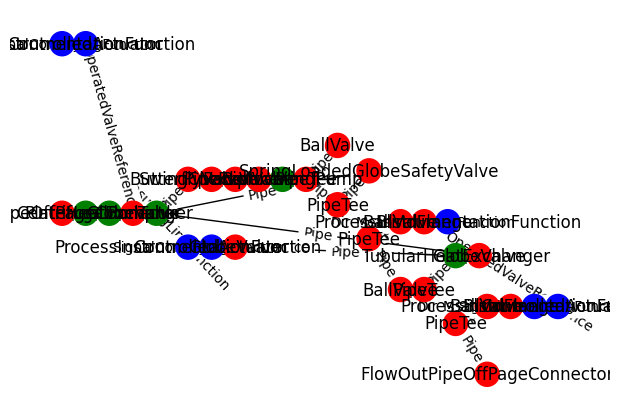

{'nodeCount': 33, 'edgeCount': 36}

In [ ]:
import matplotlib.pyplot as plt
from pydexpi.loaders import ProteusSerializer
from pydexpi.loaders.ml_graph_loader import MLGraphLoader


# Build a graph using the loader utilities that already classify piping, equipment, and instrumentation.
graph_loader = MLGraphLoader()
graph = graph_loader.dexpi_to_graph(pydexpi_model)

node_count = graph.number_of_nodes()
edge_count = graph.number_of_edges()

if node_count == 0:
    print("Exported pyDEXPI graph was empty; using the bundled DEXPI reference case for a richer visualization.")
    reference_loader = ProteusSerializer()
    reference_model = reference_loader.load(assets_dir, source_xml.name)
    graph = graph_loader.dexpi_to_graph(reference_model)
    node_count = graph.number_of_nodes()
    edge_count = graph.number_of_edges()

if node_count == 0:
    raise ValueError("Neither the exported nor reference DEXPI models produced graph nodes. Verify the earlier steps completed successfully before visualising.")

# Use the loader's built-in matplotlib helper so node colours map to DEXPI categories.
figure = graph_loader.draw_process_matplotlib()
figure.set_size_inches(6, 4)
plt.show()

{
    "nodeCount": node_count,
    "edgeCount": edge_count,
}